# 1D Laser Simulation in Python

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/1D_laser_animation.gif?raw=True" alt="drawing" width="500"/>

<a href="https://en.wikipedia.org/wiki/Laser" target="_blank">Lasers</a> are one of the most important inventions of the 20th century, and have found their way into many electronic devices found in everyday life such as the DVD player or the laser pointer. Without the laser, modern life would definitely not be as it is currently. Also perhaps quite surprisingly, laser-like phenomena have been reportedly <a href="https://en.wikipedia.org/wiki/Astrophysical_maser" target="_blank">discovered in nature</a>. In this post we will demonstrate how to use python to simulate a 1 dimensional laser by discretizing the <a href="https://en.wikipedia.org/wiki/Maxwell–Bloch_equations" target="_blank">Maxwell-Bloch equations</a> over a <a href="https://en.wikipedia.org/wiki/Finite-difference_time-domain_method" target="_blank">spatial and temporal grid</a>.

## The Maxwell Bloch Equations

The Maxwell-Bloch equations are very difficult to solve analytically, and are usually solved using numerical methods. These equations contain derivatives in both space and time, and cannot be easily solved using simple Runge-Kutta techniques as we have to integrate the equations in both space and time. Several techniques such as the <a href="https://en.wikipedia.org/wiki/Finite-difference_time-domain_method" target="_blank">Finite Difference Time Domain (FDTD)</a> or the <a href="https://ieeexplore.ieee.org/document/630102" target="_blank">Pseudo-Spectral Time Domain (PSTD)</a> are used to perform the numerical integration. In this post, we implement a one dimensional FDTD algorithm in CGS units to simulate a single port laser in python. The basics of the 1D FDTD algorithm itself is covered in another post here.

The Maxwell-Bloch equations for a laser are given by the equations below.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/Maxwell_Bloch_eq.png?raw=True" alt="drawing" width="400"/>

Equation (1) and (2) are Maxwell's equations (in CGS units, with _c_ = ε<sub>0</sub> = μ<sub>0</sub> = 1) for the electric __E__ and magnetic __H__ fields. Equation (3) describes the polarization __P__ of the lasing material. Equation (4) describes the population inversion D of a 2 level system. Equations (1) - (4) are discretised using the FDTD staggered grid, where __E__, __P__ and _D_ occupy the same grid points. 

## The FDTD Grid

In the FDTD method, we discretize the equations above using a staggered spatial and temporal grid as shown in the figure below, which allows us to numerically approximate the simultaneous solving of both coupled equations.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/fdtd_1d_grid.jpg?raw=True" alt="drawing" width="500"/>

Using the staggered FDTD grid shown in the figure above, the electric field, together with the polarization and population inversion are evaluated at integer spatial indices ..., _i_ - 1, _i_, _i_ + 1, ... (blue grid points) and integer temporal indices ..., _n_ - 1, _n_, _n_ + 1, ... while the magnetic field are evaluated at half-integer spatial indices ..., _i_ - 1/2, _i_ + 1/2, ... and half-integer temporal indices ..., _n_ - 1/2, _n_ + 1/2, ... (red grid points).

Details about the 1D FDTD electromagnetic simulation is covered in greater detail in <a href="https://github.com/natsunoyuki/blog_posts/blob/main/physics/1D%20Electromagnetic%20FDTD%20in%20Python.ipynb" target="_blank">another post</a>, so please check that post if you would like to know more.

## The FDTD Lasing Equations

The Maxwell-Bloch equations above can be discretized using the 1D FDTD grid as follows:

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/Maxwell_Bloch_1D.png?raw=True" alt="drawing" width="400"/>

In the FDTD simulation, we solve all 4 coupled differential equations simultaneously in both time and space.

## The FDTD Simulation

We encode the FDTD lasing equations in the `fdtd1d_laser` class below. This class allows us to initialize the simulation, execute the simulation and plot the results.

Also, do not forget that in our simulation we use CGS units, with _c_ = ε<sub>0</sub> = μ<sub>0</sub> = 1 to keep things simple.

`fdtd = fdtd = fdtd1d_laser()`

`fdtd.run(initiate_pulse = False)`

`fdtd.plot()`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import tqdm

# Usage:
# fdtd = fdtd = fdtd1d_laser()
# fdtd.run(initiate_pulse = True)
# fdtd.plot()

class fdtd1d_laser(object):
    # This code serves to give a demonstration of using the FDTD method to 
    # simulate a 1-dimensional laser with 1 port on the right side, and a 
    # perfectly reflecting mirror on the left side of the cavity.
    # On the left side of the integration grid a 1st order Mur boundary is
    # emplaced as the absorbing boundary conditions. Therefore the laser is
    # restricted to output only on the right side of the cavity.
    def __init__(self, Nx = 500, dx = 1, source = 99, c = 1.0, frequency = 0.1, gperp = 0.01, ka = 0.1, 
                 die1 = 1, die2 = 301, n1 = 1, n2 = 1.5, n3 = 1, D0 = 1.0):
        """FDTD input arguments in CGS units:
        Nx: number of grid cells in the x direction
        dx: grid cell size
        source: location of power source in the laser
        c: speed of light, normalized to 1 by default
        frequency: frequency of the power source
        gperp: g_perpendicular lasing parameter
        ka: ka lasing parameter (wave number)
        die1: starting location of the laser cavity dielectric
        die2: ending location of the laser cavity dielectric
        n1: refractive index of the surrounding medium
        n2: refractive index of the laser dielectric
        n3: refractive index of the output mirror
        D0: laser pump strength
        """
        
        # Initialize physical simulation parameters
        self.Nx = Nx # number of spatial grid cells in the x direction
        self.dx = dx # spatial grid cell size
        self.source = source # power source location in cells
        self.c = c # speed of light
        
        # Initialize pulse parameters
        self.frequency = frequency # frequency of the initial pulse
        self.T0 = 1.0 / frequency # period of the initial pulse
        self.tc = 5 * self.T0 / 2.0 # time constant of the initial pulse
        self.sig = self.tc / 2.0 / np.sqrt(2 * np.log(2)) # gaussian width of the initial pulse
        self.FWHM = 2 * np.sqrt(2 * np.log(2)) * self.sig # FWHM of the initial pulse
        
        # Initialize integration time step, taking into account Courant number
        self.dt = self.dx / (1.0 * self.c) # Courant magic step size = 1
        
        # Initialize Maxwell Bloch equation parameters
        self.gperp = gperp # g_perpendicular lasing parameter
        self.gpara = gperp / 100.0 # g_parallel lasing parameter
        self.ka = ka # ka lasing parameter
        
        # Initialize Maxwell Bloch Ez field and Hy field constants
        self.c1 = 1.0 / self.dt ** 2 + self.gperp / self.dt / 2.0
        self.c2 = 2.0 / self.dt ** 2 - self.ka ** 2 - self.gperp ** 2
        self.c3 = 1.0 / self.dt ** 2 - self.gperp / self.dt / 2.0
        self.c4 = self.ka * self.gperp / 2.0 / np.pi
        self.c5 = 1.0 / self.dt + self.gpara / 2.0
        self.c6 = 1.0 / self.dt - self.gpara / 2.0
        self.c7 = 2.0 * np.pi * self.gpara / ka
        self.c8 = 1.0 / self.dt + self.gperp / 2.0
        self.c9 = -1.0 / self.dt + self.gperp / 2.0
              
        # Initialize E_y and H_z field vectors in normalised CGS units
        self.E_y = np.zeros(self.Nx) 
        # staggered H_z grid which means H_z is one fewer grid cell than E_y
        self.H_z = np.zeros(self.Nx - 1) 
        
        # Initialize Mur Absorbing Boundary Conditions at the left end of the grid
        self.Ezh = 0 
        
        # Initialize dielectric slab relative permittivity and permeability
        self.E = np.ones(self.Nx) * n1 ** 2 # relative permittivity of entire grid (epsilon)
        self.E[0] = 0 # perfect reflector on the left side: permittivity = 0
        self.die1 = die1 # left most position of dielectric slab
        self.die2 = die2 # right most position of dielectric slab
        self.E[self.die1:self.die2] = n2 ** 2 # relative permittivity of the dielectric slab
        self.E[self.die2]= n3 ** 2 # relative permittivity of the output mirror
        # we assume that the dielectric is a perfect magnetic material with
        # mu = 1 everywhere. So we do not need to explicitly have a vector 
        # for mu. If this condition is not satisfied, then mu must be taken
        # into account as well in the simulation.
        
        # Initialize polarization
        self.P = np.zeros(self.Nx) # polarization vector
        self.Place = np.zeros(self.Nx) # polarization one time step before
        self.Pold = np.zeros(self.Nx) # polarization two time steps before
        
        # Initialize laser pump and population inversion
        self.D0 = D0 # pump strength (assumed to be a constant)
        self.D = np.zeros(self.Nx)
        self.D[self.die1:self.die2] = self.D0 # population inversion
        #self.D = self.D0 * np.ones(self.Nx)

        # Prepare vector to hold electric field at a particular location over 
        # the entire time frame of the FDTD loop.
        self.E_t = [] # time based field measured across the grid for animation purposes
        self.sample = int((Nx + die2) / 2) # sampling location along the x axis, 0 indexing
        self.E_measure = [] # measure time dependent field measured at a single location
        
        self.x = np.arange(0, self.Nx, 1)
        self.Dx = np.arange(1, self.Nx, 1)        
        
    def get_fields(self):
        return self.E_y, self.H_z
    
    def get_et(self):
        return self.E_t
    
    def clear_measure(self):
        self.E_measure = []

    def run(self, n_iter = 10000, initiate_pulse = False):
        # Main FDTD Loop
        for n in tqdm.trange(n_iter):
            # Update P
            self.P[self.die1:self.die2] = 1.0 / self.c1 * (self.c2 * self.P[self.die1:self.die2] - self.c3 * self.Pold[self.die1:self.die2] - self.c4 * self.E_y[self.die1:self.die2] * self.D[self.die1:self.die2])
            self.Pold = self.Place.copy() 
            self.Place = self.P.copy() # carry the current value of P for two time steps
            
            # Update E_y
            self.E_y[1:-1] = self.E_y[1:-1] - 4 * np.pi / self.E[1:-1] * (self.P[1:-1] - self.Pold[1:-1]) - self.dt / self.dx / self.E[1:-1] * np.diff(self.H_z)
            
            # Update D
            self.D[self.die1:self.die2] = 1.0 / self.c5 * (self.c6 * self.D[self.die1:self.die2] + self.gpara * self.D0 + self.c7 * self.E_y[self.die1:self.die2] * (self.c8 * self.P[self.die1:self.die2] + self.c9 * self.Pold[self.die1:self.die2]))
            
            # Initiate EM pulse
            if initiate_pulse == True:
                pulse = np.exp((-((n+1) * self.dt - 3 * np.sqrt(2) * self.sig)**2) / (2*self.sig**2))
                self.E_y[self.source] = self.E_y[self.source] + pulse
            
            # 1st order Mur Boundaries for dielectric to absorb the outgoing field on the left closed port
            self.E_y[-1] = self.Ezh + (self.c * self.dt - self.dx) / (self.c * self.dt + self.dx) * (self.E_y[-2] - self.E_y[-1])
            self.Ezh = self.E_y[-2]
            
            # Update H_z
            self.H_z = self.H_z - self.dt / self.dx * np.diff(self.E_y)
            
            # Save the time dependent data for animation, export etc.
            self.E_t.append(self.E_y.copy())
            if len(self.E_t) > 500:
                del self.E_t[0]
                
            self.E_measure.append(self.E_y[self.sample])

    def plot(self):
        # plot the E_y and H_z fields in space
        plt.figure(figsize = (10, 5))
        plt.subplot(2, 1, 1)
        rectangle = plt.Rectangle([self.die1, np.min(self.E_y)], 
                                  self.die2 - self.die1, np.max(self.E_y) - np.min(self.E_y), 
                                  color = "y", fill = True, alpha = 0.5)
        plt.gca().add_patch(rectangle)
        plt.plot(self.x, self.E_y, 'r')
        #plt.axvline(x = self.die1, color = 'k')
        #plt.axvline(x = self.die2, color = 'k', linestyle = '-.')
        plt.ylabel('E_y')
        plt.grid('on')
        plt.subplot(2, 1, 2)
        rectangle = plt.Rectangle([self.die1, np.min(self.H_z)], 
                                  self.die2 - self.die1, np.max(self.H_z) - np.min(self.H_z), 
                                  color = "y", fill = True, alpha = 0.5)
        plt.gca().add_patch(rectangle)
        plt.plot(self.Dx, self.H_z, 'g')
        #plt.axvline(x = self.die1, color = 'k')
        #plt.axvline(x = self.die2, color = 'k', linestyle = '-.')
        plt.ylabel('H_z')
        plt.xlabel("x")
        plt.grid('on')
        plt.show()
        
    def measure(self):
        # plot the measured field in time
        plt.figure(figsize = (10, 5))
        t = np.arange(0, len(self.E_measure)*self.dt, self.dt)
        plt.plot(t, self.E_measure, "r")
        plt.ylabel('E_y')
        plt.xlabel("t")
        plt.grid('on')
        plt.show()
        
    def animate(self, file_dir = "laser_animation.gif", N = 500):
        # animate self.Et as a .gif file.
        # N: number of total steps to save as .gif animation.
        Et = self.E_t[-N:]
        
        fig, ax = plt.subplots()

        rectangle = plt.Rectangle([self.die1, np.min(self.H_z)], 
                                  self.die2 - self.die1, np.max(self.H_z) - np.min(self.H_z), 
                                  color = "y", fill = True, alpha = 0.5)
        plt.gca().add_patch(rectangle)
        
        ax.set(xlim = [self.x[0] - 10, self.x[-1] + 10], 
               ylim = [-1.1 * np.max(np.abs(Et)), 1.1 * np.max(np.abs(Et))])
        line = ax.plot(range(len(Et[0])), Et[0], color = "r", linewidth = 2)[0]
        ax.set_xlabel("x")
        ax.set_ylabel("Electric field")
        ax.grid(True)
        #ax.axvline(x = self.die1, color = 'k', linewidth = 2)
        #ax.axvline(x = self.die2, color = 'k', linestyle = '-.', linewidth = 2)

        def animate(i):
            line.set_ydata(Et[i])

        anim = FuncAnimation(fig, animate, interval = 50, frames = len(Et) - 1)
        anim.save(file_dir, writer = "pillow")  
        plt.show()
        
    def plot_device(self):
        fig = plt.figure(figsize = (10, 5))
        rectangle = plt.Rectangle((self.die1, -1), self.die2 - self.die1, 2, color = "y", 
                                  fill = True, alpha = 0.5)
        plt.gca().add_patch(rectangle)
        plt.xlim([self.x[0] - 10, self.x[-1] + 10])
        plt.ylim([-1, 1])
        plt.grid(True)
        plt.show()

## Visualizing the Simulation Results

The simulator has a few ways of visualizing the results. The first method is to plot a screenshot of the current electric and magnetic fields within the laser.

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 18849.04it/s]


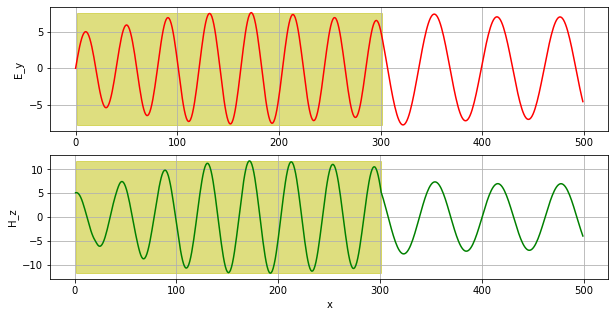

In [2]:
# Create new fdtd object.
fdtd = fdtd1d_laser()

# n_iter = 10000 runs the FDTD simulation for 10000 time steps.
# initiate_pulse = True uses an external pulse to force start the simulation.
fdtd.run(n_iter = 10000, initiate_pulse = True)

# Plot a screenshot of the current electric and magnetic fields.
fdtd.plot()

The second visualization method is to plot an animation of the electric field.

Using `matplotlib`'s `FuncAnimation` function to animate a record of _E_<sub>z</sub>(_t_), the laser can be animated for a more realistic experience of the simulation! This is already built into `fdtd1d_laser` and can be called using: `fdtd.animate()`. The animation is saved directly into a `.gif` file.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/1D_laser_animation.gif?raw=True" alt="drawing" width="500"/>

The third method is to plot the measured electric field at a specified measurement point in space, outside the laser's dielectric slab. The measurement grid point is specified in `fdtd.sample` and has a default value of `int((Nx + die2) / 2)`, which in our case equals `(500 + 300) / 2 = 400`.

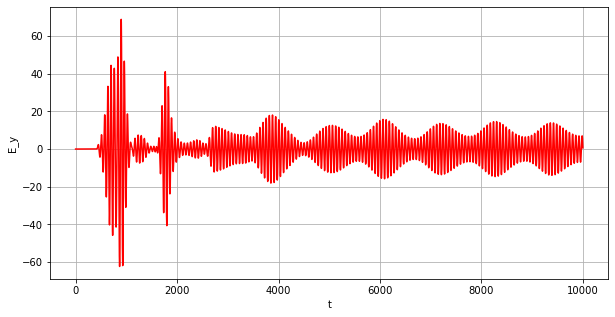

In [3]:
fdtd.measure()

## More Advanced Simulations

More FDTD codes can be found on my <a href="https://github.com/natsunoyuki/FDTD" target="_blank">Github repository</a> where I am working on both 1D and 2D laser simulations.